In [ ]:
import os
import librosa
import zipfile
from urllib.request import urlretrieve
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import SpectralClustering
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


In [ ]:
# Завантаження набору даних ESC-50
url = "https://github.com/karoldvl/ESC-50/archive/master.zip"
zip_file_path = "ESC-50-master.zip"
download_path = "./ESC-50-master/"
if not os.path.exists(download_path):
    urlretrieve(url, zip_file_path)
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(download_path)
    os.remove(zip_file_path)

df_file_path = os.path.join(download_path, "ESC-50-master/meta", "esc50.csv")
df = pd.read_csv(df_file_path)

In [ ]:
# Для зменшення обсягу даних робимо вибірку звуків із мітками 'dog' та 'chirping_birds'.
df_selected = df[df['category'].isin(['dog', 'chirping_birds'])]
df_selected.head(5)

,filename,fold,target,category,esc10,src_file,take
0,1-100032-A-0.wav,1,0,dog,True,100032,A
1,1-100038-A-14.wav,1,14,chirping_birds,False,100038,A
14,1-110389-A-0.wav,1,0,dog,True,110389,A
157,1-30226-A-0.wav,1,0,dog,True,30226,A
158,1-30344-A-0.wav,1,0,dog,True,30344,A


In [ ]:
# Завантаження аудіофайлу для прикладу
audio_file_path = os.path.join(download_path, "ESC-50-master/audio", df_selected.iloc[0]['filename'])
y, sr = librosa.load(audio_file_path, sr=None)

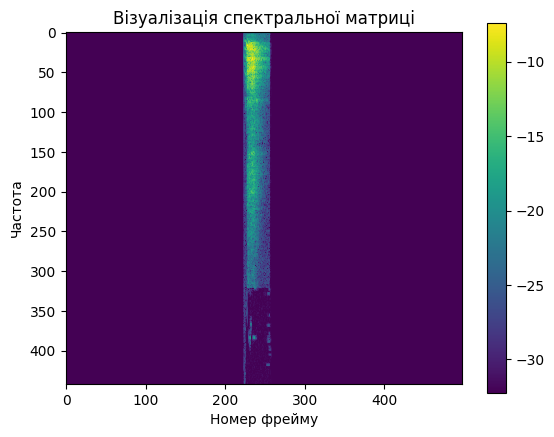

In [ ]:
# За допомогою наведеної в конспекті функції spectrogram генеруємо матрицю спектрограми.
def spectrogram(samples, sample_rate, stride_ms=10.0,
                window_ms=20.0, max_freq=None, eps=1e-14):

    stride_size = int(0.001 * sample_rate * stride_ms)
    window_size = int(0.001 * sample_rate * window_ms)

    # Extract strided windows
    truncate_size = (len(samples) - window_size) % stride_size
    samples = samples[:len(samples) - truncate_size]
    nshape = (window_size, (len(samples) - window_size) // stride_size + 1)
    nstrides = (samples.strides[0], samples.strides[0] * stride_size)
    windows = np.lib.stride_tricks.as_strided(samples,
                                              shape=nshape, strides=nstrides)

    assert np.all(windows[:, 1] == samples[stride_size:(stride_size + window_size)])

    # Window weighting, squared Fast Fourier Transform (fft), scaling
    weighting = np.hanning(window_size)[:, None]

    fft = np.fft.rfft(windows * weighting, axis=0)
    fft = np.absolute(fft)
    fft = fft ** 2

    scale = np.sum(weighting ** 2) * sample_rate
    fft[1:-1, :] *= (2.0 / scale)
    fft[(0, -1), :] /= scale

    # Prepare fft frequency list
    freqs = float(sample_rate) / window_size * np.arange(fft.shape[0])

    # Compute spectrogram feature
    specgram = np.log(fft[:, :] + eps)
    return specgram

spect_matrix_db = spectrogram(y, sr)

def spect_show(spect_matrix):
    plt.imshow(spect_matrix, cmap='viridis', interpolation='nearest')
    plt.colorbar()
    plt.title('Візуалізація спектральної матриці')
    plt.xlabel('Номер фрейму')
    plt.ylabel('Частота')
    plt.show()

spect_show(spect_matrix_db)

In [ ]:
# Використовуємо функцію pooling для узагальнення та зменшення розміру спектрограми.
def pooling_audio(mat, ksize, method='max', pad=False):
    m, n = mat.shape[:2]
    ky, kx = ksize

    _ceil = lambda x, y: int(np.ceil(x / float(y)))

    if pad:
        ny = _ceil(m, ky)
        nx = _ceil(n, kx)
        size = (ny * ky, nx * kx) + mat.shape[2:]
        mat_pad = np.full(size, np.nan)
        mat_pad[:m, :n, ...] = mat
    else:
        ny = m // ky
        nx = n // kx
        mat_pad = mat[:ny * ky, :nx * kx, ...]

    new_shape = (ny, ky, nx, kx) + mat.shape[2:]

    if method == 'max':
        result = np.nanmax(mat_pad.reshape(new_shape), axis=(1, 3))
    else:
        result = np.nanmean(mat_pad.reshape(new_shape), axis=(1, 3))

    return result

window_size = (20, 20)
decreased_spect_matrix_db = pooling_audio(spect_matrix_db, window_size)

print("Початкова матриця:")
print(np.shape(spect_matrix_db))

print("\nРезультат згортки:")
print(np.shape(decreased_spect_matrix_db))


Початкова матриця:
(442, 499)

Результат згортки:
(22, 24)


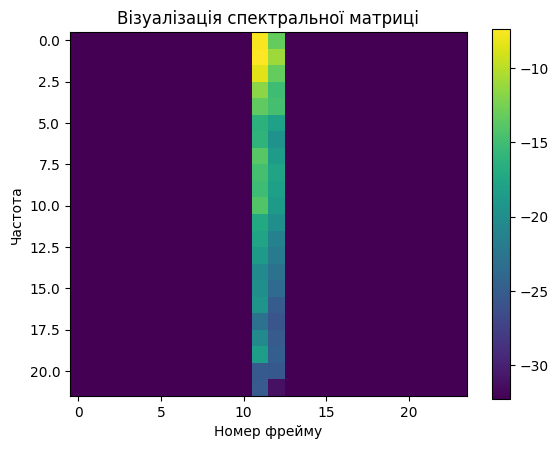

In [ ]:
# Візуалізація спектральної матриці після
spect_show(decreased_spect_matrix_db)

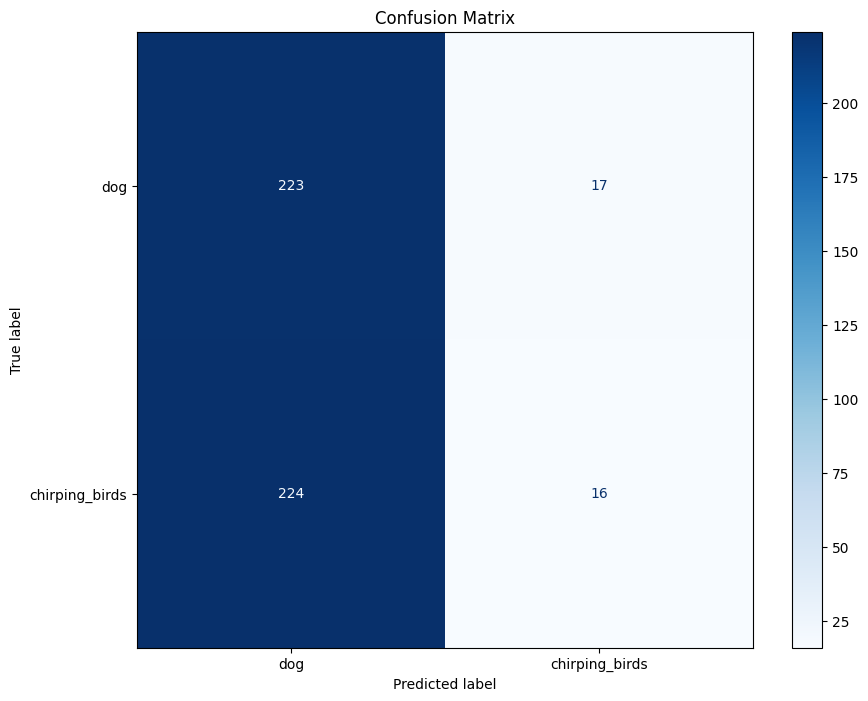

In [ ]:
# Перетворення спектрограми у вектор
flatten_decreased_spect = decreased_spect_matrix_db.flatten()

# Нормалізація даних
scaler = StandardScaler()
flatten_decreased_spect_normalized = scaler.fit_transform(flatten_decreased_spect.reshape(-1, 1))

# Спектральна кластеризація (2 кластери)
clustering = SpectralClustering(n_clusters=2, assign_labels='kmeans', random_state=42).fit(flatten_decreased_spect_normalized)
cluster_labels = clustering.labels_

# Істинні мітки для порівняння (0 для "dog", 1 для "chirping_birds")
true_labels = np.where(df_selected['category'] == 'dog', 0, 1)

# Повторюємо мітки для кожного елемента у векторі
true_labels_repeated = np.repeat(true_labels, len(flatten_decreased_spect) // len(true_labels))

# Перевірка довжини
if len(true_labels_repeated) != len(cluster_labels):
    min_len = min(len(true_labels_repeated), len(cluster_labels))
    true_labels_repeated = true_labels_repeated[:min_len]
    cluster_labels = cluster_labels[:min_len]

# Confusion Matrix
conf_matrix = confusion_matrix(true_labels_repeated, cluster_labels)

# Візуалізація Confusion Matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['dog', 'chirping_birds'])
fig, ax = plt.subplots(figsize=(10, 8))
disp.plot(ax=ax, cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

### Висновок

Ми отримали гарний результат кластерізації для Dog: із 240 зразків 223 зразки були коректно ідентифіковані, 17 помилок.

Класифікувати спів птахів не вдалось, бо в нашому аудіозапису спів птахів дуже зашумлений або можливо навіть відсутній.

Перетворення Фур'є для вилучення ознак даних спрацювало ефективно, завдяки чому наша модель має досить високу точність.